In [26]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import datetime
import iisignature as sig
from tqdm import tqdm
from plotly.offline import init_notebook_mode, iplot
from plot_metric.functions import BinaryClassification
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.svm import TimeSeriesSVC
from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
import joblib


init_notebook_mode(connected=True) ## plotly init

In [27]:
#data import
filenames_list = os.listdir('SMNI_CMI_TRAIN/Train') ## list of file names in the directory
EEG_data = pd.DataFrame({}) ## create an empty df that will hold data from each file
print(len(filenames_list))
for file_name in tqdm(filenames_list):
    temp_df = pd.read_csv('SMNI_CMI_TRAIN/Train/' + file_name) ## read from the file to df
    EEG_data = EEG_data.append(temp_df) ## add the file data to the main df

EEG_data = EEG_data.drop(['Unnamed: 0'], axis=1) ## remove the unused column
EEG_data.loc[EEG_data['matching condition'] == 'S2 nomatch,', 'matching condition'] =  'S2 nomatch' ## remove comma sign from stimulus name

468


100%|██████████| 468/468 [01:33<00:00,  4.99it/s]


In [32]:
#S1: S1 obj - a single object shown;
s1 = 0
#S12: S2 nomatch - object 2 shown in a non matching condition (S1 differed from S2)
s12 = 0
#S21: S2 match - object 2 shown in a matching condition (S1 was identical to S2),
s21 = 0
s1_X_train = np.zeros((160,256,65))
s1_y_train = np.zeros(160)
s21_X_train = np.zeros((159,256,64))
s21_y_train = np.zeros(159)
s12_X_train = np.zeros((149,256,64))
s12_y_train = np.zeros(149)


classifier = {'a':1,'c':0}

filenames_list = os.listdir('SMNI_CMI_TRAIN/Train') ## list of file names in the directory
EEG_data = pd.DataFrame({}) ## create an empty df that will hold data from each file
print(len(filenames_list))
for file_name in tqdm(filenames_list):
    temp_df = pd.read_csv('SMNI_CMI_TRAIN/Train/' + file_name) ## read from the file to df
    if temp_df["matching condition"][0] == "S1 obj":
        a = np.array(temp_df["sensor value"]).reshape([64,256])
        b = np.array(temp_df['time'][0:256]).reshape([1,256])
        s1_X_train[s1] = np.transpose(np.r_[a,b])
        s1_y_train[s1] = classifier[temp_df['subject identifier'][0]]
        s1 += 1
    if temp_df["matching condition"][0] == "S2 match":
        s21_X_train[s21] = np.transpose(np.array(temp_df["sensor value"]).reshape([64,256]))
        s21_y_train[s21] = classifier[temp_df['subject identifier'][0]]
        s21 += 1
    if temp_df["matching condition"][0] == "S2 nomatch,":
        s12_X_train[s12] = np.transpose(np.array(temp_df["sensor value"]).reshape([64,256]))
        s12_y_train[s12] = classifier[temp_df['subject identifier'][0]]
        s12 += 1
print(s1)
print(s21)
print(s12)
#t1: S1 obj - a single object shown;
t1 = 0
#t12: S2 nomatch - object 2 shown in a non matching condition (S1 differed from S2)
t12 = 0
#t21: S2 match - object 2 shown in a matching condition (S1 was identical to S2),
t21 = 0
t1_X_test = np.zeros((160,256,65))
t1_y_test = np.zeros(160)
t21_X_test = np.zeros((160,256,64))
t21_y_test = np.zeros(160)
t12_X_test = np.zeros((160,256,64))
t12_y_test = np.zeros(160)


classifier = {'a':1,'c':0}

filenames_list = os.listdir('SMNI_CMI_TEST') ## list of file names in the directory
EEG_data = pd.DataFrame({}) ## create an empty df that will hold data from each file
print(len(filenames_list))
for file_name in tqdm(filenames_list):
    if file_name == "Test":
        pass
    else:
        temp_df = pd.read_csv('SMNI_CMI_TEST/' + file_name) ## read from the file to df
        if temp_df["matching condition"][0] == "S1 obj":
            a = np.array(temp_df["sensor value"]).reshape([64,256])
            b = np.array(temp_df['time'][0:256]).reshape([1,256])
            t1_X_test[t1] = np.transpose(np.r_[a,b])
            t1_y_test[t1] = classifier[temp_df['subject identifier'][0]]
            t1 += 1
        if temp_df["matching condition"][0] == "S2 match":
            t21_X_test[t21] = np.transpose(np.array(temp_df["sensor value"]).reshape([64,256]))
            t21_y_test[t21] = classifier[temp_df['subject identifier'][0]]
            t21 += 1
        if temp_df["matching condition"][0] == "S2 nomatch,":
            t12_X_test[t12] = np.transpose(np.array(temp_df["sensor value"]).reshape([64,256]))
            t12_y_test[t12] = classifier[temp_df['subject identifier'][0]]
            t12 += 1
print(t1)
print(t21)
print(t12)


468


100%|██████████| 468/468 [00:08<00:00, 54.70it/s]


160
159
149
481


100%|██████████| 481/481 [00:08<00:00, 54.20it/s]

160
160
160


In [34]:
def score_function(X_train, y_train, X_test, y_test, clf, title, parameters = None,):
    start = datetime.datetime.now()
    if "n_jobs" in clf.get_params():
        clf = clf.set_params(**{'n_jobs': -1})
    if parameters:
        clf = clf.set_params(**parameters)
    clf.fit(X_train, y_train)
    y_pred_proba = clf.predict_proba(X_test)[:,1]
    y_pred = clf.predict(X_test)

    from plot_metric.functions import BinaryClassification
    import matplotlib.pyplot as plt
    # Visualisation with plot_metric
    from sklearn.metrics import accuracy_score
    bc = BinaryClassification(y_test, y_pred_proba, labels=["Class 0", "Class 1"])
    # Figures
    plt.figure(figsize=(5,5))
    bc.plot_roc_curve()
    plt.title(title)
    plt.show()
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    end = datetime.datetime.now()
    print(end-start)
    print("accuracy is " + str(accuracy))
    print("auc is " + str(roc_auc))
    print("f1-measure " + str(f1))
    

In [29]:
temp_df = pd.read_csv('SMNI_CMI_TRAIN/Train/Data1.csv')
a = np.array(temp_df["sensor value"]).reshape([64,256])
b = np.array(temp_df['time'][0:256]).reshape([1,256])
np.r_[a,b]


array([[-8.9210000e+00, -8.4330000e+00, -2.5740000e+00, ...,
         4.2620000e+00,  5.7270000e+00,  8.1690000e+00],
       [ 8.3400000e-01,  3.2760000e+00,  5.7170000e+00, ...,
         2.7870000e+00,  9.6230000e+00,  1.3041000e+01],
       [-1.9847000e+01, -1.2522000e+01,  1.1490000e+00, ...,
         7.0090000e+00,  1.1403000e+01,  1.2868000e+01],
       ...,
       [-8.9010000e+00, -7.9240000e+00, -3.0420000e+00, ...,
         4.7710000e+00,  6.2360000e+00,  8.6770000e+00],
       [-5.6360000e+00, -2.7060000e+00,  1.6890000e+00, ...,
         1.5849000e+01,  1.6337000e+01,  1.4872000e+01],
       [ 0.0000000e+00,  3.9062500e-03,  7.8125000e-03, ...,
         9.8828125e-01,  9.9218750e-01,  9.9609375e-01]])

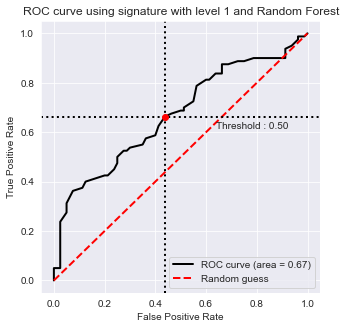

0:00:00.335483
accuracy is 0.60625
auc is 0.6700781249999999
f1-measure 0.6134969325153374


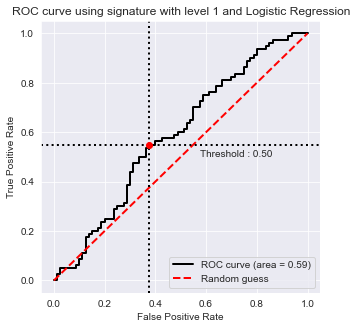

0:00:01.321428
accuracy is 0.58125
auc is 0.5859375000000001
f1-measure 0.5620915032679739


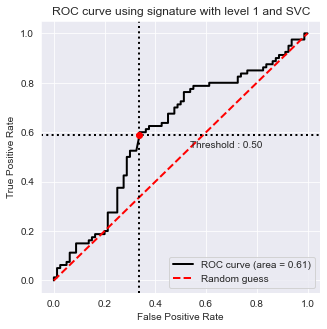

0:00:00.185204
accuracy is 0.625
auc is 0.606953125
f1-measure 0.6103896103896105


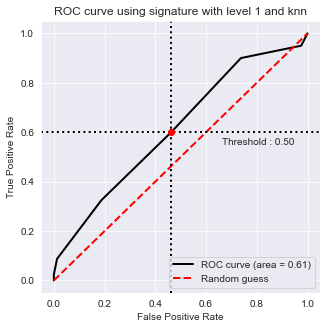

0:00:00.408879
accuracy is 0.56875
auc is 0.614296875
f1-measure 0.5818181818181819


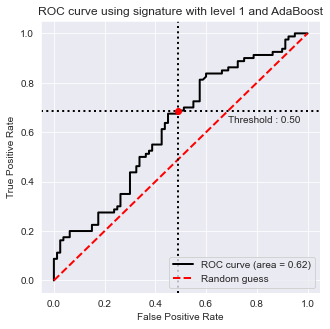

0:00:00.303701
accuracy is 0.59375
auc is 0.6189843749999998
f1-measure 0.6242774566473988


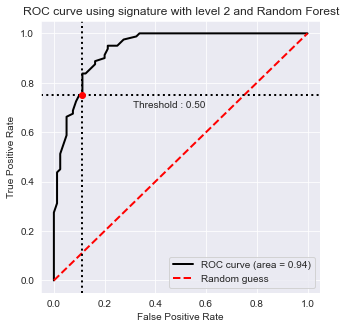

0:00:00.311192
accuracy is 0.825
auc is 0.9384375
f1-measure 0.8108108108108107


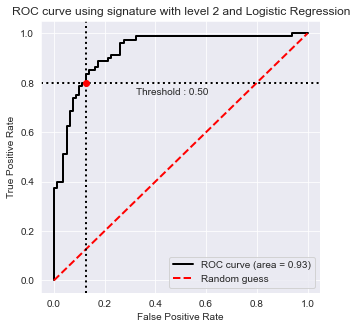

0:00:02.041295
accuracy is 0.84375
auc is 0.9253125000000002
f1-measure 0.8366013071895425


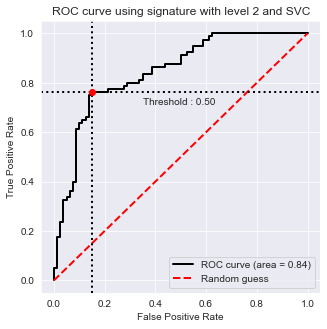

0:00:00.626706
accuracy is 0.79375
auc is 0.8435937499999999
f1-measure 0.7870967741935484


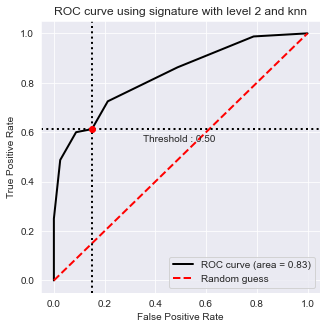

0:00:00.294797
accuracy is 0.73125
auc is 0.82984375
f1-measure 0.6950354609929078


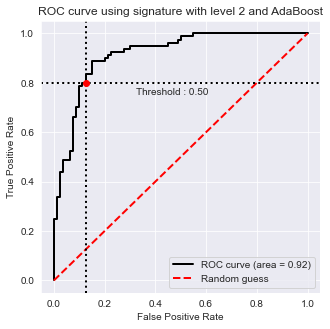

0:00:03.203175
accuracy is 0.8375
auc is 0.91625
f1-measure 0.8311688311688312


In [35]:
for i in [1,2]:
    s1_sig_train = sig.sig(s1_X_train, i)
    s1_sig_test = sig.sig(t1_X_test, i)
    
    title = "ROC curve using signature with level "+ str(i) +" and Random Forest"
    score_function(s1_sig_train,s1_y_train,s1_sig_test ,t1_y_test,
                   RandomForestClassifier(),title)
    
    title = "ROC curve using signature with level "+ str(i) +" and Logistic Regression"
    score_function(s1_sig_train,s1_y_train,s1_sig_test ,t1_y_test,
                   LogisticRegression(),title)
    
    parameters = {'probability':True}
    title = "ROC curve using signature with level "+ str(i) +" and SVC"
    score_function(s1_sig_train,s1_y_train,s1_sig_test ,t1_y_test,
                   SVC(),title,parameters)
    
    parameters = {'n_neighbors': 7}
    title = "ROC curve using signature with level "+ str(i) +" and knn"
    score_function(s1_sig_train,s1_y_train,s1_sig_test ,t1_y_test,
                   KNeighborsClassifier(),title,parameters)
    
    title = "ROC curve using signature with level "+ str(i) +" and AdaBoost"
    score_function(s1_sig_train,s1_y_train,s1_sig_test ,t1_y_test,
                   AdaBoostClassifier(),title)